## **Classificação de imagens com o Google AutoML** ##
### **Protótipo de classificação de imagens treinando um modelo com Google AutoML na Vertex AI** ###
### Parte da postagem "Criando um modelo de classificação de imagens com AutoML na Vertex AI" em www.medium.com/google-cloud-brasil

## **1. Importando os módulos necessários** ##

Os módulos que utilizaremos neste notebook são os abaixo:

In [22]:
import base64
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.cloud import storage
from google.cloud.storage import Bucket
import google.cloud.aiplatform as aiplatform

## **2. O dataset a ser utilizado** ##

Para este protótipo, iremos utilizar o [Stanford dogs dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) - um dataset curado manualmente, contendo 120 cerca de 20.000 (vinte mil) imagens de 120 (cento e vinte) raças de cachorros diferentes.

Para simplificar esse processo, iremos utilizar um *subset* deste dataset, onde utilizaremos somente 10 (dez) raças de cachorros, com 50 (cinquenta) imagens de exemplo de cada.

## **3. Configuração de projeto, região e bucket para utilização no processo** ##

In [2]:
shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
PROJECT_ID = shell_output[0]
print("Project ID:", PROJECT_ID)

Project ID: lucianomartins-demos-345000


In [3]:
REGION = "us-central1"

if REGION == "[your-region]":
    REGION = "us-central1"

In [4]:
BUCKET_NAME = "vertexai-labs"
BUCKET_URI = f"gs://{BUCKET_NAME}"

client = storage.Client()
bucket = client.bucket(BUCKET_NAME)

if not bucket.exists():
    bucket.create(location='us-central1')
    del bucket, client
    print('Criação de bucket realizada com sucesso. Bucket %s criado com sucesso' % BUCKET_NAME)
else:
    print('Criação de bucket cancelada. Bucket %s já existe' % BUCKET_NAME)

Criação de bucket realizada com sucesso. Bucket vertexai-labs criado com sucesso


## **4. Iniciando o cliente da Vertex AI** ##

In [5]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

## **5. Criando o dataset `dogs-dataset`** ##

Nesta sessão iremos:
- Baixar as imagens do dataset público de Stanford
- Processar o dataset localmente
- Exportar o sub-set do dataset para o Cloud Storage
- Criar o dataset gerenciado `dogs-dataset` na Vertex AI
- Importar as imagens do Cloud Storage no dataset gerenciado

Primeiro, utilizando uma sessão de console local, iremos baixar o dataset e processar localmente:

In [6]:
print('criando o diretório local para armazenar o dataset... ', end='')
!mkdir dataset
print('feito.')
print('realizando o download do dataset do site da universidade de Stanford... ', end='')
!cd dataset; axel -n 15 http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar -q
print('feito.')
print('descompactando o tarball do dataset... ', end='')
!cd dataset; tar -xf images.tar
print('feito.')
print('criando os diretórios do subset do dataset para treinamento e teste... ', end='')
!cd dataset/Images; for dir in `ls`; do new_name=`echo $dir | cut -d- -f2-`; mv $dir $new_name; done;
!cd dataset/Images; for dir in `find . -type d | shuf -n 15`; do dirname=`echo $dir | cut -d/ -f2`; mkdir -p ../train/$dirname; \
for img in `find $dir -type f | shuf -n 100`; do mv $img ../train/$dirname; done; done
print('feito.')
print('processamento local do dataset finalizado.')

criando o diretório local para armazenar o dataset... feito.
realizando o download do dataset do site da universidade de Stanford... feito.
descompactando o tarball do dataset... feito.
criando os diretórios do subset do dataset para treinamento e teste... feito.
processamento local do dataset finalizado.


Agora copiamos as imagens de treinamento para o Cloud Storage bucket que criamos:

In [7]:
!gsutil -m cp -r dataset/train/* $BUCKET_URI/cachorros-dataset

Copying file://dataset/train/African_hunting_dog/n02116738_5932.jpg [Content-Type=image/jpeg]...
Copying file://dataset/train/African_hunting_dog/n02116738_288.jpg [Content-Type=image/jpeg]...
Copying file://dataset/train/African_hunting_dog/n02116738_2192.jpg [Content-Type=image/jpeg]...
Copying file://dataset/train/African_hunting_dog/n02116738_204.jpg [Content-Type=image/jpeg]...
Copying file://dataset/train/African_hunting_dog/n02116738_2614.jpg [Content-Type=image/jpeg]...
Copying file://dataset/train/African_hunting_dog/n02116738_2988.jpg [Content-Type=image/jpeg]...
Copying file://dataset/train/African_hunting_dog/n02116738_4461.jpg [Content-Type=image/jpeg]...
Copying file://dataset/train/African_hunting_dog/n02116738_8945.jpg [Content-Type=image/jpeg]...
Copying file://dataset/train/African_hunting_dog/n02116738_4641.jpg [Content-Type=image/jpeg]...
Copying file://dataset/train/African_hunting_dog/n02116738_5241.jpg [Content-Type=image/jpeg]...
Copying file://dataset/train/Afr

E criamos o arquivo *json* com todas as imagens para serem importadas no dataset gerenciado da Vertex AI:

In [8]:
print('gerando a lista de imagens por raça de cachorro... ', end='')
!gsutil ls -r $BUCKET_URI/cachorros-dataset | grep jpg > dataset/list.out
print('feito.')
print('gerando o arquivo csv com a classe/raça e a imagem correspondente... ', end='')
!rm -rf dataset/dataset.csv
!for img in `cat dataset/list.out`; do classe=`echo $img | cut -d/ -f5`; echo "${img},${classe}" >> dataset/dataset.csv; done
print('feito.')
print('copiando o csv com todas as imagens para o bucket no Cloud Storage... ', end='')
!gsutil -q cp dataset/dataset.csv $BUCKET_URI/cachorros-dataset
print('feito.')

gerando a lista de imagens por raça de cachorro... feito.
gerando o arquivo csv com a classe/raça e a imagem correspondente... feito.
copiando o csv com todas as imagens para o bucket no Cloud Storage... feito.


Criando o dataset gerenciado da Vertex AI com as imagens das raças de cachorro no Cloud Storage:

In [9]:
%%time

dataset = aiplatform.ImageDataset.create(display_name='cachorros-dataset',
                                        sync=True)

Creating ImageDataset
Create ImageDataset backing LRO: projects/48397268769/locations/us-central1/datasets/6546815488196870144/operations/2097098733815595008
ImageDataset created. Resource name: projects/48397268769/locations/us-central1/datasets/6546815488196870144
To use this ImageDataset in another session:
ds = aiplatform.ImageDataset('projects/48397268769/locations/us-central1/datasets/6546815488196870144')
CPU times: user 36 ms, sys: 22.3 ms, total: 58.3 ms
Wall time: 2.8 s


Com o dataset criado, podemos verificar algumas de suas informações:

In [10]:
print(dataset.display_name)
print(dataset.name)
print(dataset.resource_name)

cachorros-dataset
6546815488196870144
projects/48397268769/locations/us-central1/datasets/6546815488196870144


Agora podemos importar as imagens para dentro do dataset gerenciado:

In [11]:
%%time

dataset = dataset.import_data(gcs_source=BUCKET_URI + '/cachorros-dataset/dataset.csv', 
                              import_schema_uri=aiplatform.schema.dataset.ioformat.image.single_label_classification,
                              sync=True,
                              import_request_timeout=2700.0)

Importing ImageDataset data: projects/48397268769/locations/us-central1/datasets/6546815488196870144
Import ImageDataset data backing LRO: projects/48397268769/locations/us-central1/datasets/6546815488196870144/operations/2145512429809827840
ImageDataset data imported. Resource name: projects/48397268769/locations/us-central1/datasets/6546815488196870144
CPU times: user 326 ms, sys: 142 ms, total: 468 ms
Wall time: 20min 1s


## **6. Iniciando o treinamento com Google AutoML na Vertex AI**

Com o dataset pronto, é hora de iniciar o treinamento do modelo. O AutoML será responsável por gerir todas as ações necessárias de *split* de dataset, preparação de modelos candidatos, treinamento e otimização desses modelos e seleção do melhor modelo. Precisamos executar apenas duas ações - a definição do job de treinamento:

In [12]:
job = aiplatform.AutoMLImageTrainingJob(
    display_name='treinamento de classificador de cachorros',
    prediction_type='classification',
    multi_label=False,
    model_type='CLOUD',
    base_model=None)

print(job)

Com a definição do job realizada, podemos iniciar a execução do treinamento do modelo:

In [13]:
%%time

model = job.run(
    dataset=dataset,
    model_display_name='classificador-cachorros',
    training_fraction_split=0.8,
    validation_fraction_split=0.1,
    test_fraction_split=0.1,
    budget_milli_node_hours=10000,
    disable_early_stopping=False,
    create_request_timeout=43200.0)

View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/8401561174688137216?project=48397268769
AutoMLImageTrainingJob projects/48397268769/locations/us-central1/trainingPipelines/8401561174688137216 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLImageTrainingJob projects/48397268769/locations/us-central1/trainingPipelines/8401561174688137216 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLImageTrainingJob projects/48397268769/locations/us-central1/trainingPipelines/8401561174688137216 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLImageTrainingJob projects/48397268769/locations/us-central1/trainingPipelines/8401561174688137216 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLImageTrainingJob projects/48397268769/locations/us-central1/trainingPipelines/8401561174688137216 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLImageTrainingJob projects/48397268769/locations/us-central1/trainingPipelines/84015

A Vertex AI oferece métricas do modelo após o treinamento, para facilitar a nossa análise de qualidade do modelo. Aqui um exemplo de como podemos interagir com essas métricas:

In [14]:
model_evaluations = model.list_model_evaluations()

for model_evaluation in model_evaluations:
    print(model_evaluation.to_dict())

{'name': 'projects/48397268769/locations/us-central1/models/4167564684666339328@1/evaluations/5273414928256991232', 'metricsSchemaUri': 'gs://google-cloud-aiplatform/schema/modelevaluation/classification_metrics_1.0.0.yaml', 'metrics': {'confusionMatrix': {'rows': [[10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

## **7. Deploy do modelo AutoML em uma API** ##

Para que o modelo possa ser utilizado por desenvolvedores e acessado por outros serviços/APIs, é importante que ele esteja disponível também em uma API. Para isso utilizaremos os [Vertex AI endpoints](https://cloud.google.com/vertex-ai/docs/general/deployment).

Para isso, só precisamos chamar o método que executa a implantação (ou *deployment*) do modelo recem treinado:

In [ ]:
%%time

endpoint = model.deploy()

Creating Endpoint
Create Endpoint backing LRO: projects/48397268769/locations/us-central1/endpoints/4148637691505803264/operations/4732830415734177792
Endpoint created. Resource name: projects/48397268769/locations/us-central1/endpoints/4148637691505803264
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/48397268769/locations/us-central1/endpoints/4148637691505803264')
Deploying model to Endpoint : projects/48397268769/locations/us-central1/endpoints/4148637691505803264
Deploy Endpoint model backing LRO: projects/48397268769/locations/us-central1/endpoints/4148637691505803264/operations/3148407771829895168


## **8. Realizando inferências utilizando a API do modelo de classificação de imagens** ##

Com o modelo disponibilizado na API, agora podemos enviar imagens e o modelo realizará a predição sobre qual classe a imagem faz parte.

Para isso, usaremos a SDK da Vertex AI e enviaremos a imagem de interesse em `base64`. Conforme abaixo:

In [39]:
raca = !cd dataset/train; for folder in `find . -type d | shuf -n 1`; do for filename in `find $folder -type f | shuf -n 1`; \
do rm -rf ../../imgs; mkdir ../../imgs; cp ${filename} ../../imgs/testimg.jpg; done; done; echo $folder
raca = raca[0].split('/')[1]

with open('./imgs/testimg.jpg', 'rb') as image_file:
    imagem = base64.b64encode(image_file.read())

Agora, enviaremos a imagem, em formato `base64`, para a API do modelo.

Utilizaremos a imagem abaixo para predição (parte do dataset de cachorros de Stanford):

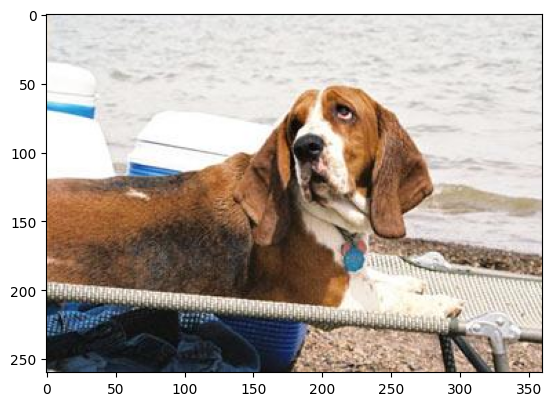

basset


In [40]:
img = mpimg.imread('./imgs/testimg.jpg')
imgplot = plt.imshow(img)
plt.show()
print(raca)

In [41]:
instances = [{"content": imagem.decode("utf-8")}]
prediction = endpoint.predict(instances=instances)

Analisando o resultado da predição, vemos que o modelo aprendeu corretamente como identificar raças de cachorro (podemos comparar o resultado da inferência com a legenda da imagem acima):

In [42]:
id_raca = prediction[0][0]['confidences'].index(max(prediction[0][0]['confidences']))
prediction[0][0]['displayNames'][id_raca]

'basset'

Parabéns!! chegando até aqui você:
- criou um dataset gerenciado na Vertex AI
- treinou um modelo de machine learning, em uma abordagem *low code*, utilizando o Google AutoML
- fez a implantação desse modelo em uma API
- realizou inferências com esse modelo.

## **9. Desconstruindo o ambiente** ##
Caso você queira desconstruir seu ambiente de teste, execute esta última célula:

In [43]:
# retira o modelo da API REST criada na Vertex AI Endpoint
endpoint.undeploy_all()

# deleta a Vertex AI Endpoint criada
endpoint.delete()

# remove o modelo da model registry
model.delete()

# deleta as informações do job de treinamento
job.delete()

# caso queira remover o bucket criado, defina a variável delete_bucket como True
# caso queira mante-lo, defina a variável delete_bucket como False
delete_bucket = True

if delete_bucket:
    ! gsutil -m -q rm -r $BUCKET_URI

# deleta o dataset baixado do site da universidade de Stanford
! rm -rf dataset

Undeploying Endpoint model: projects/48397268769/locations/us-central1/endpoints/4148637691505803264
Undeploy Endpoint model backing LRO: projects/48397268769/locations/us-central1/endpoints/4148637691505803264/operations/5796524352723746816
Endpoint model undeployed. Resource name: projects/48397268769/locations/us-central1/endpoints/4148637691505803264
Deleting Endpoint : projects/48397268769/locations/us-central1/endpoints/4148637691505803264
Delete Endpoint  backing LRO: projects/48397268769/locations/us-central1/operations/6138797924403904512
Endpoint deleted. . Resource name: projects/48397268769/locations/us-central1/endpoints/4148637691505803264
Deleting Model : projects/48397268769/locations/us-central1/models/4167564684666339328
Delete Model  backing LRO: projects/48397268769/locations/us-central1/operations/3832954915190210560
Model deleted. . Resource name: projects/48397268769/locations/us-central1/models/4167564684666339328
Deleting AutoMLImageTrainingJob : projects/48397